<a href="https://colab.research.google.com/github/minwoongPark/TEST/blob/main/2_tf2_CNN_ResNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow as tf
 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [ ]:
# 패키지 임포트
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터 세트 표준
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
# 데이터 세트 셰이프 확인
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


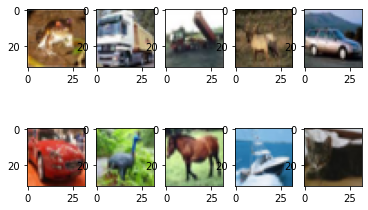

In [ ]:
# 데이터 세트 이미지 확인
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [ ]:
# 데이터 세트 라벨 확인
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [ ]:
# 데이터 세트 전처리
train_images = train_images
train_labels = to_categorical(train_labels)
test_images = test_images
test_labels = to_categorical(test_labels)

In [ ]:
# 데이터 세트 전처리 후 셰이프 확인
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
# 컨볼루셔널 레이어 생성
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False,
        kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [ ]:
# 레지듀얼 블록 A 생성
def first_residual_unit(filters, strides):
    def f(x):
        # →BN→ReLU
        x = BatchNormalization()(x)
        b = Activation('relu')(x)

        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # 컨볼루셔널 레이어→
        x = conv(filters, 1)(x)

        # 숏컷 셰이프 사이즈 조정
        sc = conv(filters, 1, strides)(b)

        # Add
        return Add()([x, sc])
    return f

In [ ]:
# 레지듀얼 블록 B 생성
def residual_unit(filters):
    def f(x):
        sc = x
        
        # →BN→ReLU
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→
        x = conv(filters, 1)(x)

        # Add
        return Add()([x, sc])
    return f

In [ ]:
# 레지듀얼 블록 A와 레지듀얼 블록 B x unit_size-1 생성
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)  # (None, 32, 32, 16)
        for i in range(unit_size-1):
            x = residual_unit(filters)(x)  # (None, 32, 32, 64)
        return x
    return f

In [ ]:
# 입력 데이터 셰이프
input = Input(shape=(32,32, 3))

# 컨볼루셔널 레이어
x = conv(16, 3)(input)  # (None, 32, 32, 16)

# 레지듀얼 블록 x 54
x = residual_block(64, 1, 18)(x)  # (None, 32, 32, 64)  stride-1
x = residual_block(128, 2, 18)(x)  # (None, 16, 16, 128)  stride-2
x = residual_block(256, 2, 18)(x)  # (None, 8, 8, 256)  stride-2

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 풀링 레이어
x = GlobalAveragePooling2D()(x)  # (None, 256)

# 전결합 레이어
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)  # (None, 10)

# 모델 생성
model = Model(inputs=input, outputs=output)

In [ ]:
# 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   432         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [ ]:
# ImageDataGenerator 준비
train_gen  = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    width_shift_range=0.125, 
    height_shift_range=0.125, 
    horizontal_flip=True)
test_gen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True)

# 데이터 세트 전체 총합량을 미리 계산
for data in (train_gen, test_gen):
    data.fit(train_images)

In [ ]:
# LearningRateScheduler 준비
def step_decay(epoch):
    x = 0.1
    if epoch >= 80: x = 0.01
    if epoch >= 120: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay)

In [ ]:
%%time
# colab : 약 3시간 소요됨, local :
# 학습
batch_size = 128
history = model.fit_generator(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=100,
    steps_per_epoch=train_images.shape[0] // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps=test_images.shape[0] // batch_size,
    callbacks=[lr_decay])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/100
390/390 [==============================] - 117s 224ms/step - loss: 4.4877 - acc: 0.3713 - val_loss: 4.0816 - val_acc: 0.4749 - lr: 0.1000
Epoch 2/100
390/390 [==============================] - 84s 214ms/step - loss: 3.6545 - acc: 0.5619 - val_loss: 3.7741 - val_acc: 0.5128 - lr: 0.1000
Epoch 3/100
390/390 [==============================] - 84s 215ms/step - loss: 3.1214 - acc: 0.6433 - val_loss: 3.1286 - val_acc: 0.6182 - lr: 0.1000
Epoch 4/100
390/390 [==============================] - 83s 212ms/step - loss: 2.7136 - acc: 0.6974 - val_loss: 2.6678 - val_acc: 0.6806 - lr: 0.1000
Epoch 5/100
390/390 [==============================] - 84s 215ms/step - loss: 2.3849 - acc: 0.7350 - val_loss: 2.3132 - val_acc: 0.7268 - lr: 0.1000
Epoch 6/100
390/390 [==============================] - 81s 208ms/step - loss: 2.1156 - acc: 0.7618 - val_loss: 2.0725 - val_acc: 0.7516 - lr: 0.1000
Epoch 7/100
390/390 [==============================] - 85s 217ms/step - loss: 1.8852 - acc: 0.7844 - val_

In [ ]:
# 모델 저장
model.save('resnet.h5')

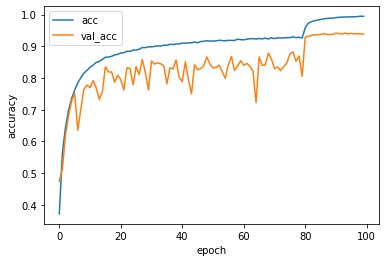

In [ ]:
# 그래프 표시
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# 평가
batch_size = 128
test_loss, test_acc = model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """


loss: 0.489
acc: 0.931


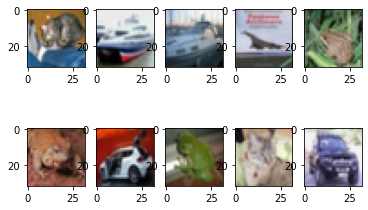

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [ ]:
# 추론할 이미지 표시
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 추론한 라벨 표시
test_predictions = model.predict_generator(
    test_gen.flow(test_images[0:10], shuffle = False, batch_size=1),
    steps=10)
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])